# Stock Price Prediction End To End ML App (Rev 11/20/23)

- PyTorch (Not TF)
- yfinance (for now just use NASDAQ directly)
- matplotlib
- numpy
- pandas
- streamlit (?)

**Contributor**: James Guzman

**Teammates**: Josef, Anshul

**Project Advisor**: Dr. Magdalini Eirinaki

**SJSU CMPE 256**: Advanced Data Mining

**Date**: Nov 17, 2023

Based on "Machine Learning Project in Python to Predict Stock Price ML End to End Application":

- https://youtu.be/P3JlMWoP3fE?si=XxIz2Zo8GCt9ziHM

Based on "Amazon Stock Forecasting in PyTorch with LSTM Neural Network (Time Series Forecasting) | Tutorial 3":

- https://www.youtube.com/watch?v=q_HS4s1L8UI

Planning to Contribute our Semester Project to H2O Wave App Store (Currently, I submitted a project idea to their discussion forum on GitHub):

- https://github.com/h2oai/wave/discussions/2200

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from copy import deepcopy as dc
from tqdm.notebook import tqdm
# import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# import streamlit
    # streamlit they use to deploy as a web app, for now I will use Wave or PySide6

In [2]:
LEARNING_RATE = 1e-2
BATCH_SIZE = 16
TEST_BATCH_SIZE = 1
NUM_EPOCHS = 10
DEBUG = True

dataset_name = "stock_closing_price"

device = torch.device("cuda")
print(f"Running on GPU {torch.cuda.get_device_name(device)}")

Running on GPU NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [3]:
train_mse_loss_avg_values = []
train_rmse_loss_avg_values = []

valid_mse_loss_avg_values = []
valid_rmse_loss_avg_values = []

## Helper Classes & Functions

In [4]:
def mkdir_prep_dir(dirpath):
    """make preprocess directory if doesn't exist"""
    prep_dir = dirpath
    if not os.path.exists(prep_dir):
        os.makedirs(prep_dir)
    return prep_dir

def save_checkpoint(state, filename="best_lstm.pth.tar"):
    print("=> Saving Checkpoint")
    torch.save(state, filename)

def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))


In [5]:
# Ideally, I am thinking of parts of the preprocessing pipeline code, I can refactor toward nifi later
# Need a better telemetry dashboard to interact with NiFi: Unity, H2O Wave, PySide6 QT
class DataPrepPipeline:
    def __init__(self):
        pass

    # NOTE (JG): my save predictions method later should be based on how we address 100 days here
    # def split_features_labels(self, stock_features_labels_data, num_days=100):
    #     # num_days = 100 by default
    #     x_features_2d_list = [] # features: ex 100 days of final closing prices
    #     y_labels_list = [] # labels: ex 100th day of final closing price gt to be pred

    #     count = 0
    #     for i in range(num_days, stock_features_labels_data.shape[0]):
    #         # x_features_list is a 2D list where each element of 100 elements are 1D array with single element
    #         if DEBUG and count == 0:
    #             print(f"stock_features_labels_data[i-num_days:i] = {stock_features_labels_data[i-num_days:i]}")

    #         x_features_per_num_days = []
    #         for j in range(len(stock_features_labels_data[i-num_days:i])):
    #             if DEBUG and count == 0:
    #                 print(f"j = {j}")
    #                 print(f"stock_features_labels_data[j][0] = {stock_features_labels_data[j][0]}") # only one item per list within list
    #             x_features_per_num_days.append(stock_features_labels_data[j][0])
    #         x_features_2d_list.append(x_features_per_num_days)
    #         if DEBUG and count == 0:
    #             print(f"x_features_2d_list = {x_features_2d_list}")
    #             print(f"stock_features_labels_data[i,0] = {stock_features_labels_data[i,0]}")
    #         y_labels_list.append(stock_features_labels_data[i,0])
    #         count += 1
        
    #     return x_features_2d_list, y_labels_list

    # Based on Greg Hogg's Stock Pred Video: https://youtu.be/q_HS4s1L8UI?si=CHWvbvfoPExQcALa
    def prepare_df_for_lstm(self, stock_df, n_steps):
        """
        # 10 days stock price
        # it'll take the first 10 days, to then predict 11th day stock price
        # 10, 11, 12, 15, 16, 17, 18, 19, 20, 17, "18"
        # for the 12th day prediction, it'll take the 11th back to the 1st day
        # .., 11, 12, 15, 16, 17, 18, 19, 20, 17, 18, "19"
        """
        stock_df = dc(stock_df)
        stock_df["Date"] = pd.to_datetime(stock_df["Date"])

        stock_df.set_index("Date", inplace=True)

        for i in range(1, n_steps+1):
            stock_df[f"Close(t-{i})"] = stock_df["Close"].shift(i)

        stock_df.dropna(inplace=True)

        return stock_df

    def split_features_labels(self, stock_features_labels_pd):
        x_features = stock_features_labels_pd[:, 1:]
        y_labels = stock_features_labels_pd[:, 0]

        if DEBUG:
            print(f"x_features shape = {x_features.shape}; y_labels shape = {y_labels.shape}")
        return x_features, y_labels

In [6]:
class PyTorchPipeline:
    def __init__(self):
        pass

    def train_model(self, train_loader, lstm_model, optimizer, loss_criterion):
        train_loop = tqdm(train_loader)

        train_mse_loss_values = []
        train_rmse_loss_values = []

        # closing_price_2d_tensor
        for batch_idx, (closing_price_2d_tensor, final_closing_price_tensor_gt) in enumerate(train_loop):
            # final_closing_price_tensor_gt = final_closing_price_tensor.unsqueeze(1)

            optimizer.zero_grad()
            closing_price_2d_tensor = closing_price_2d_tensor.to(device)
            final_closing_price_tensor_gt = final_closing_price_tensor_gt.to(device)
            pred_final_closing_price = lstm_model(closing_price_2d_tensor)
            mse_loss = loss_criterion(pred_final_closing_price, final_closing_price_tensor_gt)
            rmse_loss = rmse(pred_final_closing_price, final_closing_price_tensor_gt)

            mse_loss.backward()
            optimizer.step()

            train_mse_loss_values.append(mse_loss.item())
            train_rmse_loss_values.append(rmse_loss.item())

            train_loop.set_postfix(train_mse_loss=mse_loss.item(), train_rmse_loss=rmse_loss.item())

        train_mse_loss_avg_values.append( sum(train_mse_loss_values)/len(train_loader) )
        train_rmse_loss_avg_values.append( sum(train_rmse_loss_values)/len(train_loader) )

    def validate_model(self, val_loader, lstm_model, loss_criterion):
        val_loop = tqdm(val_loader)

        val_mse_loss_values = []
        val_rmse_loss_values = []

        for batch_idx, (closing_price_2d_tensor, final_closing_price_tensor_gt) in enumerate(val_loop):
            # final_closing_price_tensor_gt = final_closing_price_tensor.unsqueeze(1)
            closing_price_2d_tensor = closing_price_2d_tensor.to(device)
            final_closing_price_tensor_gt = final_closing_price_tensor_gt.to(device)
            
            pred_final_closing_price = lstm_model(closing_price_2d_tensor)
            mse_loss = loss_criterion(pred_final_closing_price, final_closing_price_tensor_gt)
            rmse_loss = rmse(pred_final_closing_price, final_closing_price_tensor_gt)


            val_mse_loss_values.append(mse_loss.item())
            val_rmse_loss_values.append(rmse_loss.item())

            val_loop.set_postfix(val_mse_loss=mse_loss.item(), val_rmse_loss=rmse_loss.item())

        valid_mse_loss_avg_values.append( sum(val_mse_loss_values)/len(val_loader) )
        valid_rmse_loss_avg_values.append( sum(val_rmse_loss_values)/len(val_loader) )

    def train_over_epochs(self, train_loader, test_loader, lstm_model, optimizer, loss_criterion, dst_folder="lstm_model"):
        step = 100
        for epoch in range(NUM_EPOCHS):
            self.train_model(train_loader, lstm_model, optimizer, loss_criterion)

            checkpoint = {
                "state_dict": lstm_model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }

            mkdir_prep_dir(f"{dataset_name}/{dst_folder}")
            filename = f"{dataset_name}/{dst_folder}/lstm_model_{step}.pth.tar"
            save_checkpoint(checkpoint, filename=filename)

            self.validate_model(test_loader, lstm_model, loss_criterion)

            step += 100

    def deploy_model(self, test_loader, lstm_model):
        test_loop = tqdm(test_loader)
        final_closing_price_predictions = []
        final_closing_price_gts = []
        count = 0

        for batch_idx, (closing_price_2d_tensor, final_closing_price_tensor) in enumerate(test_loop):
            closing_price_2d_tensor = closing_price_2d_tensor.to(device)
            final_closing_price_pred = lstm_model(closing_price_2d_tensor)
            # if DEBUG and count == 0:
            print(f"final_closing_price_pred.item() = {final_closing_price_pred.item()}")
            final_closing_price_predictions.append(final_closing_price_pred.item())
            final_closing_price_gts.append(final_closing_price_tensor.item())
            count += 1
        return final_closing_price_gts, final_closing_price_predictions

    def test_dataloader_sample(self, data_loader):
        for batch_idx, (closing_price_features_tensor, closing_price_labels_tensor) in enumerate(data_loader):
            closing_price_features_tensor = closing_price_features_tensor.to(device)
            closing_price_labels_tensor = closing_price_labels_tensor.to(device)
            print(f"close price features shape: {closing_price_features_tensor.shape}; close price labels shape: {closing_price_labels_tensor.shape}")
            break

In [7]:
class PyTorchUtility:
    def __init__(self):
        pass

    # TODO (JG): Add arguments for naming the two labels
    def plot_loss_curves(self, train_loss_values, test_loss_values, plot_title, plot_filename):
        f, ax = plt.subplots()
        ax.set_title(plot_title)
        ax.plot(train_loss_values, color="blue", label="Train RMSE")
        ax.plot(test_loss_values, color="gold", label="Valid RMSE")
        ax.grid(True)
        ax.set_xlabel("Epochs")
        ax.set_ylabel("RMSE Loss")
        plt.legend()
        plt.savefig(plot_filename)
        plt.show()

    
    def plot_gt_pred_curves(self, final_closing_price_gts, final_closing_price_predictions, plot_title, plot_filename):
        f, ax = plt.subplots()
        ax.set_title(plot_title)
        ax.plot(final_closing_price_predictions, color="blue", label="Pred Price")
        ax.plot(final_closing_price_gts, color="gold", label="GT Price")
        ax.grid(True)
        ax.set_xlabel("Time")
        ax.set_ylabel("Price")
        plt.legend()
        plt.savefig(plot_filename)
        plt.show()


    # TODO (JG): Need to check num_days preds for closing price. Is it suppose to be over
    def save_lstm_predictions(self, stock_test_date_df, final_closing_price_predictions, scale, num_days, dst_folder="lstm_model", filename="pytorch_final_closing_price_preds.csv"):
        # test_close_price_df, google_stock_train_date
        stock_date_list = []
        # y_train_list = []

        count = 0
        for i in range(num_days, stock_test_date_df.shape[0]):
            # if DEBUG and count == 0:
            #     print(f"stock_test_date_df[0] = {stock_test_date_df[0]}")
            #     print(f"stock_test_date_df[i,0] = {stock_test_date_df[i,0]}")
                
            stock_pred_date_id = stock_test_date_df.Date.iloc[i]
            if DEBUG and count == 0:
                print(f"stock_pred_date_id = {stock_pred_date_id}")
            stock_date_list.append(stock_pred_date_id)
            count += 1

        mkdir_prep_dir(f"{dataset_name}/{dst_folder}")
        dst_filepath = f"{dataset_name}/{dst_folder}/{filename}"

        # final_closing_price_unscaled_preds = final_closing_price_predictions*scale
        
        # final close price pred for each 100th date after predicting on 100 days of final closing prices
        stock_close_price_res_df = pd.DataFrame({f"{num_days}th Date": stock_date_list, "Close": final_closing_price_predictions})
        stock_close_price_res_df.to_csv(dst_filepath, index=False)
        return stock_close_price_res_df


## Load NASDAQ Symbols Metadata

In [8]:
# Load Stock Market Data
nasdaq_meta_symbols_filepath = "/home/james/src/datasets/NASDAQ_Yahoo_Finance/symbols_valid_meta.csv"

In [9]:
nasdaq_symbols_meta_pd = pd.read_csv(nasdaq_meta_symbols_filepath)

In [10]:
nasdaq_symbols_meta_pd.head()

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
0,Y,A,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
1,Y,AA,Alcoa Corporation Common Stock,N,,N,100.0,N,NaN,AA,AA,N
2,Y,AAAU,Perth Mint Physical Gold ETF,P,,Y,100.0,N,NaN,AAAU,AAAU,N
3,Y,AACG,ATA Creativity Global - American Depositary Sh...,Q,G,N,100.0,N,N,NaN,AACG,N
4,Y,AADR,AdvisorShares Dorsey Wright ADR ETF,P,,Y,100.0,N,NaN,AADR,AADR,N


In [11]:
nasdaq_symbols_meta_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8049 entries, 0 to 8048
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Nasdaq Traded     8049 non-null   object 
 1   Symbol            8049 non-null   object 
 2   Security Name     8049 non-null   object 
 3   Listing Exchange  8049 non-null   object 
 4   Market Category   8049 non-null   object 
 5   ETF               8049 non-null   object 
 6   Round Lot Size    8049 non-null   float64
 7   Test Issue        8049 non-null   object 
 8   Financial Status  3383 non-null   object 
 9   CQS Symbol        4666 non-null   object 
 10  NASDAQ Symbol     8049 non-null   object 
 11  NextShares        8049 non-null   object 
dtypes: float64(1), object(11)
memory usage: 754.7+ KB


## Load NASDAQ Stock Data If Company Is In Metadata

In [12]:
stock_dir_path = "/home/james/src/datasets/NASDAQ_Yahoo_Finance/stocks"

In [13]:
symbol_name = "GOOG"

In [14]:
if symbol_name in nasdaq_symbols_meta_pd["Symbol"].tolist():
    print(f"{symbol_name} is in NASDAQ Yahoo Finance Metadata, loading GOOG stock pd")
    google_stock_data_pd = pd.read_csv(os.path.join(stock_dir_path, f"{symbol_name}.csv"))

GOOG is in NASDAQ Yahoo Finance Metadata, loading GOOG stock pd


In [15]:
google_stock_data_pd.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
3,2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100


In [16]:
google_stock_data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3932 entries, 0 to 3931
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3932 non-null   object 
 1   Open       3932 non-null   float64
 2   High       3932 non-null   float64
 3   Low        3932 non-null   float64
 4   Close      3932 non-null   float64
 5   Adj Close  3932 non-null   float64
 6   Volume     3932 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 215.2+ KB


## Create Moving Average Stock Across 100 Days

We'll create moving average stock across 100 days

In [17]:
num_days = 100

In [18]:
mavg_100_days = google_stock_data_pd.Close.rolling(num_days).mean()

### Plot Moving Average vs Close Price

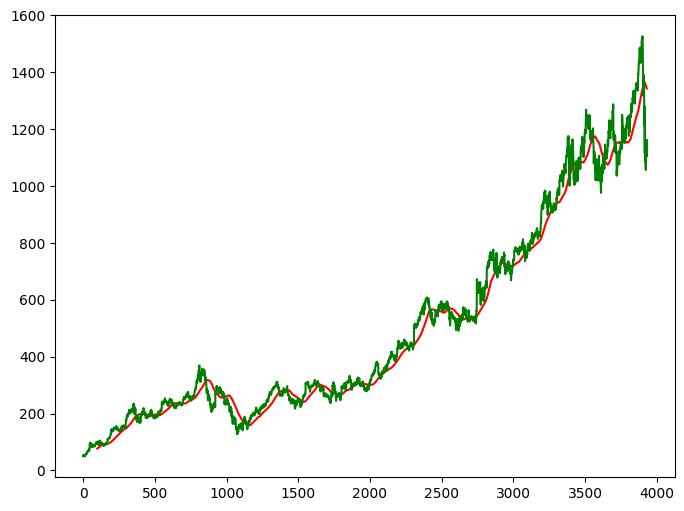

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(mavg_100_days, "r")
plt.plot(google_stock_data_pd.Close, "g")
plt.show()

## Create Moving Average Stock Across 200 Days

In [20]:
num_days = 200
mavg_200_days = google_stock_data_pd.Close.rolling(num_days).mean()

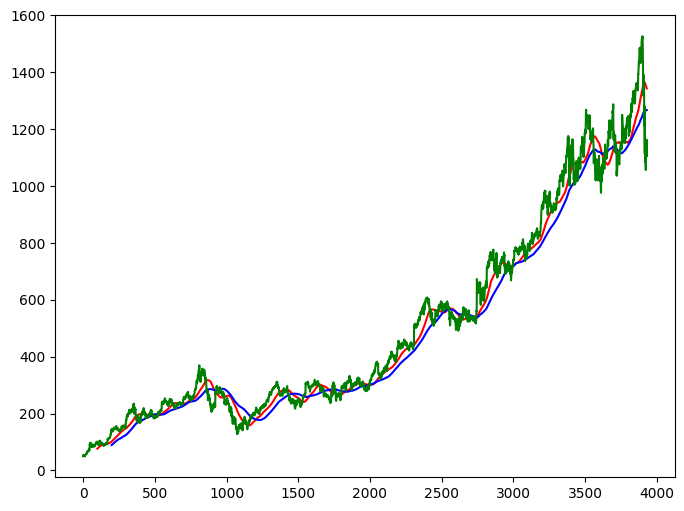

In [21]:
plt.figure(figsize=(8,6))
plt.plot(mavg_100_days, "r")
plt.plot(mavg_200_days, "b")
plt.plot(google_stock_data_pd.Close, "g")
plt.show()

## Clean NAs from Stock Data

Double check how to find number of NAs

In [22]:
google_stock_data_pd.dropna(inplace=True)

## Filter for Date & Close Price

In [23]:
google_stock_date_close_pd = google_stock_data_pd[["Date", "Close"]]

In [24]:
google_stock_date_close_pd

,Date,Close
0,2004-08-19,49.982655
1,2004-08-20,53.952770
2,2004-08-23,54.495735
3,2004-08-24,52.239193
4,2004-08-25,52.802086
...,...,...
3927,2020-03-26,1161.750000
3928,2020-03-27,1110.709961
3929,2020-03-30,1146.819946
3930,2020-03-31,1162.810059


## Plot Date as PD Date Type

/tmp/ipykernel_24853/636717400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  google_stock_date_close_pd["Date"] = pd.to_datetime(google_stock_date_close_pd["Date"])


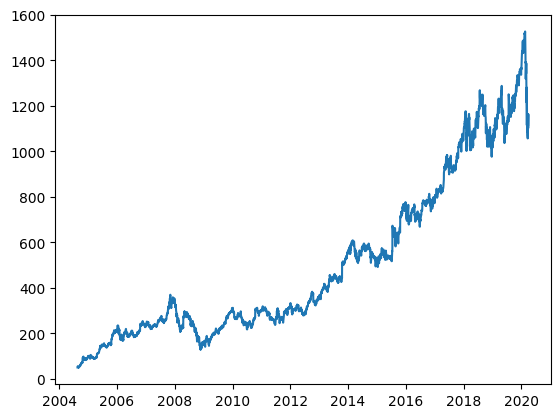

In [25]:
google_stock_date_close_pd["Date"] = pd.to_datetime(google_stock_date_close_pd["Date"])

plt.plot(google_stock_date_close_pd["Date"], google_stock_date_close_pd["Close"])

In [26]:
nifi_pipeline = DataPrepPipeline()

In [27]:
# number of days we're tracking for the features with respect to the 8th day we're predicting
lookback = 7

In [28]:
google_stock_fets_labels_df = nifi_pipeline.prepare_df_for_lstm(google_stock_date_close_pd, n_steps=lookback)

In [29]:
google_stock_fets_labels_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2004-08-30,50.814533,52.876804,53.753517,52.802086,52.239193,54.495735,53.952770,49.982655
2004-08-31,50.993862,50.814533,52.876804,53.753517,52.802086,52.239193,54.495735,53.952770
2004-09-01,49.937820,50.993862,50.814533,52.876804,53.753517,52.802086,52.239193,54.495735
2004-09-02,50.565468,49.937820,50.993862,50.814533,52.876804,53.753517,52.802086,52.239193
2004-09-03,49.818268,50.565468,49.937820,50.993862,50.814533,52.876804,53.753517,52.802086
...,...,...,...,...,...,...,...,...
2020-03-26,1161.750000,1102.489990,1134.459961,1056.619995,1072.319946,1115.290039,1096.800049,1119.800049
2020-03-27,1110.709961,1161.750000,1102.489990,1134.459961,1056.619995,1072.319946,1115.290039,1096.800049
2020-03-30,1146.819946,1110.709961,1161.750000,1102.489990,1134.459961,1056.619995,1072.319946,1115.290039


In [93]:
google_stock_fets_labels_df["Date"]

KeyError: 'Date'

## Scale Features On (-1, 1) via MinMaxScaler

Scale training data between 0 and 1

In [30]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [31]:
google_stock_fets_labels_df_scale = scaler.fit_transform(google_stock_fets_labels_df)

In [32]:
google_stock_fets_labels_df_scale

array([[-0.99865084, -0.99585809, -0.99467083, ..., -0.99366571,
        -0.994401  , -0.99977739],
       [-0.99840799, -0.99865084, -0.99585809, ..., -0.99672155,
        -0.99366571, -0.994401  ],
       [-0.9998381 , -0.99840799, -0.99865084, ..., -0.99595927,
        -0.99672155, -0.99366571],
       ...,
       [ 0.48557481,  0.43667417,  0.5057933 , ...,  0.36342479,
         0.38468588,  0.44287658],
       [ 0.50722884,  0.48557481,  0.43667417, ...,  0.46883675,
         0.36342479,  0.38468588],
       [ 0.42978127,  0.50722884,  0.48557481, ...,  0.42554257,
         0.46883675,  0.36342479]])

In [33]:
x_stock_fets_list, y_stock_labels_list = nifi_pipeline.split_features_labels(google_stock_fets_labels_df_scale)

x_features shape = (3925, 7); y_labels shape = (3925,)


## Split Stock 60% for Train, 20% for Valid & 20% for Test

In [34]:
train_ratio = 0.60
valid_ratio = 0.20 + train_ratio # 0.80
test_ratio = 0.20

In [35]:
train_split_index = int(len(x_stock_fets_list) * train_ratio)
train_split_index

2355

In [36]:
valid_split_index = int(len(x_stock_fets_list)*valid_ratio)
valid_split_index

3140

In [37]:
test_split_index = len(x_stock_fets_list)
test_split_index

3925

In [38]:
# 60% for training features: 0 to 60%
X_google_stock_train = x_stock_fets_list[0: train_split_index]

# 20% for validation features: 60% to 80%
X_google_stock_valid = x_stock_fets_list[train_split_index: valid_split_index]

# 20% for testing features
X_google_stock_test = x_stock_fets_list[valid_split_index: test_split_index]


y_google_stock_train = y_stock_labels_list[0: train_split_index]

y_google_stock_valid = y_stock_labels_list[train_split_index: valid_split_index]

y_google_stock_test = y_stock_labels_list[valid_split_index: test_split_index]

In [39]:
# google_stock_train_date = pd.DataFrame(google_stock_data_pd.Date[0: int(len(google_stock_data_pd)*0.80)])
# google_stock_test_date = pd.DataFrame(google_stock_data_pd.Date[int(len(google_stock_data_pd)*0.80): len(google_stock_data_pd)])

In [40]:
# google_stock_test_date.shape

In [41]:
# print(google_stock_test_date.Date.iloc[0])

In [42]:
# We dont see 100 since back at google_stock_train, we havent yet split features from labels
print(f"stock_train X shape = {X_google_stock_train.shape}; stock_train y shape =  {y_google_stock_train.shape}")

stock_train X shape = (2355, 7); stock_train y shape =  (2355,)


In [43]:
print(f"stock_valid X shape = {X_google_stock_valid.shape}; stock_valid y shape =  {y_google_stock_valid.shape}")

stock_valid X shape = (785, 7); stock_valid y shape =  (785,)


In [44]:
print(f"stock_test X shape = {X_google_stock_test.shape}; stock_test y shape =  {y_google_stock_test.shape}")

stock_test X shape = (785, 7); stock_test y shape =  (785,)


In [45]:
X_google_stock_test[:5]

array([[0.04862422, 0.04160941, 0.04360014, 0.04196151, 0.03441853,
        0.02885273, 0.02725477],
       [0.05391924, 0.04862422, 0.04160941, 0.04360014, 0.04196151,
        0.03441853, 0.02885273],
       [0.05878083, 0.05391924, 0.04862422, 0.04160941, 0.04360014,
        0.04196151, 0.03441853],
       [0.05756208, 0.05878083, 0.05391924, 0.04862422, 0.04160941,
        0.04360014, 0.04196151],
       [0.058334  , 0.05756208, 0.05878083, 0.05391924, 0.04862422,
        0.04160941, 0.04360014]])

In [46]:
# taken last 100 days from training set
# google_stock_train_pas_100_days = google_stock_train.tail(100)

In [47]:
# google_stock_test = pd.concat([google_stock_train_pas_100_days, google_stock_test],
#                                ignore_index=True)

In [48]:
# google_stock_test

In [49]:
print(f"len(x_stock_fets_list) = {len(x_stock_fets_list)}")
print(f"total google stock on splits = {X_google_stock_train.shape[0] + X_google_stock_valid.shape[0] + X_google_stock_test.shape[0]}")

len(x_stock_fets_list) = 3925
total google stock on splits = 3925


## Add Extra Dimension for LSTM Prep

Add an extra dimension to X stock training, validation and testing sets accounting for lookback.
Add an extra dimension to y stock training, validation and testing sets.

In [50]:
X_google_stock_train = X_google_stock_train.reshape( (-1, lookback, 1) )
X_google_stock_valid = X_google_stock_valid.reshape( (-1, lookback, 1) )
X_google_stock_test = X_google_stock_test.reshape( (-1, lookback, 1) )

y_google_stock_train = y_google_stock_train.reshape( (-1, 1) )
y_google_stock_valid = y_google_stock_valid.reshape( (-1, 1) )
y_google_stock_test = y_google_stock_test.reshape( (-1, 1) )

In [51]:
print(f"stock_train X shape = {X_google_stock_train.shape}; stock_train y shape =  {y_google_stock_train.shape}")
print(f"stock_valid X shape = {X_google_stock_valid.shape}; stock_valid y shape =  {y_google_stock_valid.shape}")
print(f"stock_test X shape = {X_google_stock_test.shape}; stock_test y shape =  {y_google_stock_test.shape}")

stock_train X shape = (2355, 7, 1); stock_train y shape =  (2355, 1)
stock_valid X shape = (785, 7, 1); stock_valid y shape =  (785, 1)
stock_test X shape = (785, 7, 1); stock_test y shape =  (785, 1)


## Create PyTorch Nasdaq Dataset (Train, Valid, Test)

In [52]:
class NasdaqTimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, stock_close_price_fets, stock_close_price_labels):
        self.stock_close_price_fets_ = stock_close_price_fets
        self.stock_close_price_labels_ = stock_close_price_labels
        self.count_ = 0

    def __len__(self):
        return len(self.stock_close_price_fets_)

    def __getitem__(self, idx):
        if DEBUG and self.count_ == 0:
            print(f"NasdaqDataset __getitem__ idx = {idx}")
        # each array holds 100 days of closing prices
        closing_price_features = self.stock_close_price_fets_[idx]
        closing_price_features_tensor = torch.tensor(closing_price_features).float()

        if DEBUG and self.count_ == 0:
            print(f"closing_price_features_tensor.shape = {closing_price_features_tensor.shape}")
        
        closing_price_labels = self.stock_close_price_labels_[idx]
        closing_price_labels_tensor = torch.tensor(closing_price_labels).float()

        if DEBUG and self.count_ == 0:
            print(f"closing_price_labels_tensor.shape = {closing_price_labels_tensor.shape}")

        self.count_ += 1
        
        return closing_price_features_tensor, closing_price_labels_tensor

In [53]:
# x_train_fets_array, y_train_labels_array = np.array(x_train_fets_list), np.array(y_train_labels_list)
# x_valid_fets_array, y_valid_labels_array = np.array(x_valid_fets_list), np.array(y_valid_labels_list)
# x_test_fets_array, y_test_labels_array = np.array(x_test_fets_list), np.array(y_test_labels_list)

In [54]:
stock_train_dataset = NasdaqTimeSeriesDataset(X_google_stock_train, y_google_stock_train)

In [55]:
stock_valid_dataset = NasdaqTimeSeriesDataset(X_google_stock_valid, y_google_stock_valid)

In [56]:
stock_test_dataset = NasdaqTimeSeriesDataset(X_google_stock_test, y_google_stock_test)

## Create PyTorch Nasdaq DataLoader (Train, Test)

In [57]:
stock_train_loader = DataLoader(stock_train_dataset, batch_size = BATCH_SIZE, shuffle=True)

In [58]:
stock_valid_loader = DataLoader(stock_valid_dataset, batch_size = TEST_BATCH_SIZE, shuffle=False)

In [59]:
stock_test_loader = DataLoader(stock_test_dataset, batch_size = TEST_BATCH_SIZE, shuffle=False)

In [60]:
pytorch_pipeline = PyTorchPipeline()

In [61]:
pytorch_pipeline.test_dataloader_sample(stock_train_loader)

NasdaqDataset __getitem__ idx = 1678
closing_price_features_tensor.shape = torch.Size([7, 1])
closing_price_labels_tensor.shape = torch.Size([1])
close price features shape: torch.Size([16, 7, 1]); close price labels shape: torch.Size([16, 1])


## Create a PyTorch LSTM Model

Based on our "x" and "y" training data, we'll create a ML model and then train it

In [62]:
# Use nn.LSTM, nn.Linear, nn.ReLU, nn.Dropout

In [63]:
# rows = 2259, columns, ch
# NOTE: use to be "x"
# x_train_fets_array.shape

In [69]:
class StockClosePriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=10, num_stacked_layers=1):
        super(StockClosePriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)
        # self.dropout1 = nn.Dropout(0.2)
        # self.relu = nn.ReLU()

        self.count_ = 0

    def forward(self, closing_price_2d_features):
        # closing price 2D features: row by col, each row has 100 samples since 100 days of closing prices, 
        # trying to pred final closing price
        if DEBUG and self.count_ == 0:
            print(f"type(closing_price_2d_features) = {type(closing_price_2d_features)}")
        batch_size = closing_price_2d_features.size(0)
        if DEBUG and self.count_ == 0:
            print(f"closing_price_2d_features batch_size = {batch_size}")
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        lstm_features, lstm_hidden = self.lstm(closing_price_2d_features, (h0, c0))
        lstm_features = lstm_features[:, -1, :]
        if DEBUG and self.count_ == 0:
            print(f"type(lstm_features) = {type(lstm_features)}")
        # lstm_relu = self.relu(lstm_features)
        # lstm_dropout = self.dropout1(lstm_relu)

        stock_price_pred = self.fc(lstm_features)

        self.count_ += 1
        return stock_price_pred

In [70]:
# lstm_model = StockPriceLSTM(num_days=x_train_fets_array.shape[1], hidden_size=10)
lstm_model = StockClosePriceLSTM(input_size=1, hidden_size=4, num_stacked_layers=1)

In [71]:
lstm_model.to(device)

StockClosePriceLSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [72]:
mse_criterion = nn.MSELoss()

In [73]:
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)

## Train PyTorch LSTM Model using Pipeline

In [74]:
# pytorch_pipeline = PyTorchPipeline()

In [75]:
pytorch_pipeline.train_over_epochs(
    stock_train_loader, stock_valid_loader,
    lstm_model,
    lstm_optimizer,
    mse_criterion,
    dst_folder="lstm_stock_close"
)

  0%|          | 0/148 [00:00<?, ?it/s]

type(closing_price_2d_features) = <class 'torch.Tensor'>
closing_price_2d_features batch_size = 16
type(lstm_features) = <class 'torch.Tensor'>
=> Saving Checkpoint


  0%|          | 0/785 [00:00<?, ?it/s]

NasdaqDataset __getitem__ idx = 0
closing_price_features_tensor.shape = torch.Size([7, 1])
closing_price_labels_tensor.shape = torch.Size([1])


  0%|          | 0/148 [00:00<?, ?it/s]

=> Saving Checkpoint


  0%|          | 0/785 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

=> Saving Checkpoint


  0%|          | 0/785 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/148 [00:00<?, ?it/s]

=> Saving Checkpoint


  0%|          | 0/785 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

=> Saving Checkpoint


  0%|          | 0/785 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

=> Saving Checkpoint


  0%|          | 0/785 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [76]:
pytorch_utility = PyTorchUtility()

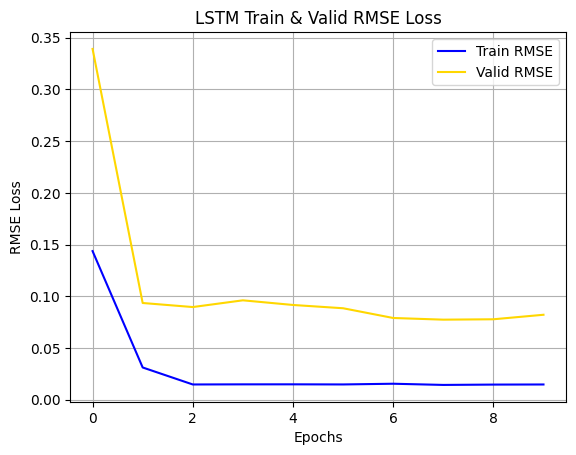

In [77]:
pytorch_utility.plot_loss_curves(train_rmse_loss_avg_values, valid_rmse_loss_avg_values,
                                 "LSTM Train & Valid RMSE Loss", "lstm_train_valid_loss_avg_curves.jpg")

In [78]:
final_train_rmse = min(train_rmse_loss_avg_values)
print(f"LSTM: final_train Min RMSE = {final_train_rmse}")

LSTM: final_train Min RMSE = 0.014215184706798126


In [79]:
final_test_rmse = min(valid_rmse_loss_avg_values)
print(f"LSTM: final_valid Min RMSE = {final_test_rmse}")

LSTM: final_valid Min RMSE = 0.07733356772334712


In [80]:
final_closing_price_gts, final_closing_price_predictions = pytorch_pipeline.deploy_model(stock_test_loader, lstm_model)

  0%|          | 0/785 [00:00<?, ?it/s]

NasdaqDataset __getitem__ idx = 0
closing_price_features_tensor.shape = torch.Size([7, 1])
closing_price_labels_tensor.shape = torch.Size([1])
final_closing_price_pred.item() = -0.17718422412872314
final_closing_price_pred.item() = -0.1762092113494873
final_closing_price_pred.item() = -0.17502281069755554
final_closing_price_pred.item() = -0.1740185171365738
final_closing_price_pred.item() = -0.17342770099639893
final_closing_price_pred.item() = -0.17289158701896667
final_closing_price_pred.item() = -0.17198362946510315
final_closing_price_pred.item() = -0.17156682908535004
final_closing_price_pred.item() = -0.171272873878479
final_closing_price_pred.item() = -0.17142203450202942
final_closing_price_pred.item() = -0.17152851819992065
final_closing_price_pred.item() = -0.17178033292293549
final_closing_price_pred.item() = -0.17168577015399933
final_closing_price_pred.item() = -0.17161747813224792
final_closing_price_pred.item() = -0.1706329882144928
final_closing_price_pred.item() = -0.

## Unscale Final Closing Stock Price Predictions

In [85]:
unscale = 1/scaler.scale_

In [86]:
np.array([unscale[0]])

array([738.43583679])

In [87]:
final_closing_price_unscaled_preds = final_closing_price_predictions*np.array([unscale[0]])

In [88]:
final_closing_price_unscaled_gts = final_closing_price_gts*np.array([unscale[0]])

It looks like we are getting correct predictions in which I mean they are not the same for every set of features. We maybe able to improve the predictions if we increase the lookback from 7 to 100 days that we predict on. We'll test that next. I have two graphs, one with scaled predicted stock closing prices and the other with unscaled predicted stock closing prices. It seems like our initial issue where we were getting the same predictions for each set of features was happening because of the way we were using dropout and relu. **For now the simple LSTM neural network architecture works, we'll build on top of it to improve it.**

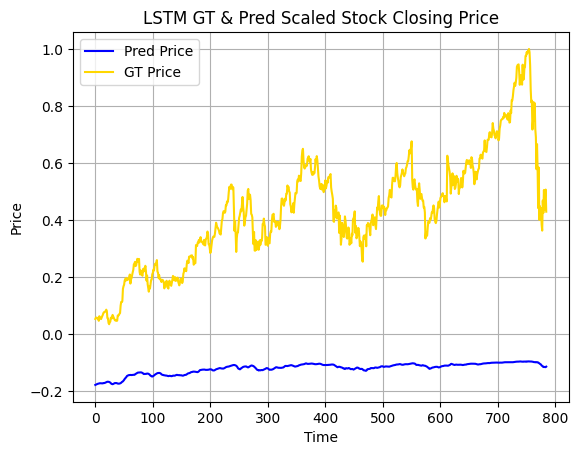

In [89]:
pytorch_utility.plot_gt_pred_curves(final_closing_price_gts, final_closing_price_predictions,
                    "LSTM GT & Pred Scaled Stock Closing Price", "lstm_gt_pred_scaled_stock_close_price_curves.jpg")

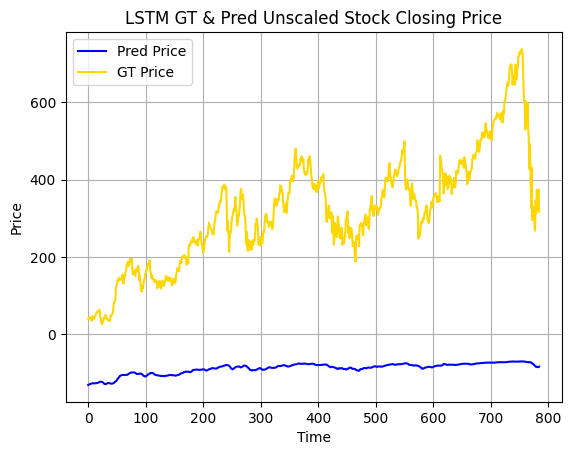

In [90]:
pytorch_utility.plot_gt_pred_curves(final_closing_price_unscaled_gts, final_closing_price_unscaled_preds,
                    "LSTM GT & Pred Unscaled Stock Closing Price", "lstm_gt_pred_unscaled_stock_close_price_curves.jpg")

In [92]:
pytorch_utility.save_lstm_predictions(google_stock_test_date, final_closing_price_unscaled_preds, np.array([unscale[0]]),
                                       num_days=100, dst_folder="lstm_stock_close/unscaled_predictions/", 
                                       filename="pytorch_final_closing_price_unscaled_preds.csv")

NameError: name 'google_stock_test_date' is not defined